In [2]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

%matplotlib inline

данные первого этапа

In [3]:
data = pd.read_csv('../input/datapytorch/data/250k_rndm_zinc_drugs_clean_3.csv')
data = data.smiles
data = data[:75000]
print(data.shape)

(75000,)


In [ ]:
data

данные второго этапа

In [ ]:
data = pd.read_csv('../input/datapytorch/data/250k_rndm_zinc_drugs_clean_3.csv')
data = data[:150000]

In [ ]:
filter1 = data.logP > 1.0
filter2 = data.qed > 0.5
filter3 = data.logP <3.0

In [ ]:
data.where(filter1 & filter2 & filter3, inplace = True)


In [ ]:
data = data.dropna()

In [ ]:
data = data['smiles']
len(data)

In [ ]:
data

Данные третьего этапа

In [ ]:
data = pd.read_csv('../input/datapytorch/data/250k_rndm_zinc_drugs_clean_3.csv')
data = data[:150000]

In [ ]:
filter1 = data.logP > -0.4
filter2 = data.qed > 0.75
filter3 = data.logP < 5.6

In [ ]:
data.where(filter1 & filter2 & filter3, inplace = True)
data = data.dropna()
data = data['smiles'].values
len(data)

In [4]:
class KLDivergenceLayer(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_loss = K.exp(log_var) + K.square(mu) - 1 - log_var
        kl_loss = 0.5*kl_loss
        kl_loss = K.mean(kl_loss)
        self.add_loss(kl_loss, inputs=inputs)
        
        return inputs

class SamplingLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(SamplingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        z_sigma = K.exp(0.5*z_log_var)
        eps = K.random_normal(shape=(tf.shape(inputs[0])))
        z = z_mean + z_sigma * eps
        return (z_mean, z_sigma, z)

In [5]:
class SmilesVAE():
    def __init__(self,
                 latent_dim,
                 encoder_lstm_units,
                 encoder_hidden_layer_sizes,
                 decoder_lstm_units,
                 decoder_hidden_layer_sizes,
                 epochs,
                 batch_size):
        self.latent_dim = latent_dim
        self.encoder_lstm_units = encoder_lstm_units
        self.decoder_lstm_units = decoder_lstm_units
        self.encoder_hidden_layer_sizes = encoder_hidden_layer_sizes
        self.decoder_hidden_layer_sizes = decoder_hidden_layer_sizes
        self.epochs = epochs
        self.batch_size = batch_size
        
    def __build_vocab__(self, data):
        self.vocab = set("".join(data) + "!E")
        self.vocab_size = len(self.vocab)
        self.max_smiles_length = max([len(s) for s in data]) + 5
        self.char_to_idx = {c: i for i, c in enumerate(self.vocab)}
        self.idx_to_char = {i: c for i, c in enumerate(self.vocab)}
    
    def __vectorize__(self, data):
        one_hot = np.zeros((data.shape[0], self.max_smiles_length, self.vocab_size), dtype='int')
        for i, smile in enumerate(data):
            one_hot[i, 0, self.char_to_idx['!']] = 1
            for j, c in enumerate(smile):
                one_hot[i, j+1, self.char_to_idx[c]] = 1
            one_hot[i, len(smile)+1:, self.char_to_idx['E']] = 1
        return one_hot
        
    def __build_encoder__(self):
        input_shape = (self.max_smiles_length - 1, len(self.vocab))
        encoder_inputs = keras.layers.Input(shape=input_shape)

        lstm_output, state_h, state_c = keras.layers.LSTM(self.encoder_lstm_units, return_state=True, unroll=False,recurrent_dropout=0.1,
                                dropout=0.2)(encoder_inputs)
        x = keras.layers.Concatenate(axis=-1)([state_h, state_c])
        for hidden_layer_size in self.encoder_hidden_layer_sizes:
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
        z_mean = keras.layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = keras.layers.Dense(self.latent_dim, name='z_log_var')(x)
        z_mean, z_log_var = KLDivergenceLayer(name='KLD')([z_mean, z_log_var])
        z_mean, z_sigma, z = SamplingLayer(name='Sampling')([z_mean, z_log_var])
        
        encoder = keras.Model(encoder_inputs, [z_mean, z_sigma, z], name='encoder')
        self.encoder = encoder
        #encoder.summary()
    
    def __build_decoder__(self):
        z = keras.layers.Input(shape=(self.latent_dim,))
        decoder_inputs = keras.layers.Input(shape=(self.max_smiles_length - 1, self.vocab_size))
        
        x = z
        for hidden_layer_size in self.decoder_hidden_layer_sizes:
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
        state_h = keras.layers.Dense(self.decoder_lstm_units, activation='relu')(x)
        state_c = keras.layers.Dense(self.decoder_lstm_units, activation='relu')(x)
        
        self.latent_to_states = keras.Model(z, [state_h, state_c])
        
        x = keras.layers.LSTM(self.decoder_lstm_units, return_sequences=True, unroll=False,recurrent_dropout=0.2,
                                dropout=0.2)(decoder_inputs, initial_state=[state_h, state_c])
        decoder_outputs = keras.layers.Dense(self.vocab_size, activation='softmax')(x)
        
        decoder = keras.Model([decoder_inputs, z], decoder_outputs, name='decoder')
        self.decoder = decoder
    
    def __build_VAE__(self):

        self.__build_encoder__()
        self.__build_decoder__()
        
        vae_inputs = keras.layers.Input(shape=(self.max_smiles_length - 1, self.vocab_size))
        _, _, z = self.encoder(vae_inputs)
        vae_outputs = self.decoder([vae_inputs, z])
        
        vae = keras.Model(vae_inputs, vae_outputs, name='VAE')
        self.vae = vae

    def __vae_loss__(self, x_true, x_pred):
        x_true = K.cast(x_true, 'float')
        x_pred = K.cast(x_pred, 'float')
        const = K.cast(K.shape(x_true)[1], 'float32') * K.cast(K.shape(x_true)[2], 'float32')
        return K.mean(const * K.categorical_crossentropy(x_true, x_pred))

    def __build_sample_model__(self):
        sample_model_inputs = keras.layers.Input(batch_shape=(1, 1, self.vocab_size))
        x = keras.layers.LSTM(self.decoder_lstm_units, return_sequences=True, unroll=False, stateful=True)(sample_model_inputs)
        sample_model_outputs = keras.layers.Dense(self.vocab_size, activation='softmax')(x)
        sample_model = keras.Model(sample_model_inputs, sample_model_outputs)
        
        sample_model.layers[-2].set_weights(self.decoder.layers[-2].get_weights())
        sample_model.layers[-1].set_weights(self.decoder.layers[-1].get_weights())
        
        self.sample_model = sample_model
        self.sample_model.save('sample_model.h5')
        
        
    def train(self, data):
        self.__build_vocab__(data)        
        trainX = self.__vectorize__(data)
        
        np.random.seed(42)
        X = trainX[:, :-1, :]
        Y = trainX[:, 1:, :]
                
        self.__build_VAE__()
        opt = keras.optimizers.Adam(lr=1e-4)
        self.vae.compile(optimizer=opt, loss=self.__vae_loss__)
        
        h = keras.callbacks.History()
        self.vae.fit(X, 
                     Y,
                     epochs=self.epochs, 
                     batch_size=self.batch_size, 
                     shuffle=True, 
                     callbacks=[h])
        self.encoder.save("smiles_2_latent.h5")
        self.latent_to_states.save("latent_to_states.h5")   
        self.decoder.save("decoder.h5")
        self.__build_sample_model__()

    def sample(self, latent_vec):
        states = self.latent_to_states(latent_vec)
        self.sample_model.layers[1].reset_states(states=[states[0], states[1]])

        smiles_string = ''
        x_input = np.zeros((1, 1, self.vocab_size))
        x_input[0, 0, self.char_to_idx['!']] = 1

        for i in range(vae.max_smiles_length):
            prediction = self.sample_model.predict(x_input)
            char_idx = np.argmax(prediction)
            char_pred = self.idx_to_char[char_idx]
            if char_pred != 'E':
                smiles_string = smiles_string + char_pred
                x_input = np.zeros((1, 1, self.vocab_size))
                x_input[0, 0, char_idx] = 1
            else:
                break

        return smiles_string

In [6]:
vae = SmilesVAE(latent_dim=64,
                encoder_lstm_units=128,
                encoder_hidden_layer_sizes=(128,),
                decoder_lstm_units=128,
                decoder_hidden_layer_sizes=(128,),
                epochs=100,
                batch_size=512)
vae.train(data)

2022-05-06 08:23:23.904265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 08:23:24.003079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 08:23:24.004231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 08:23:24.006208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Starting to train...


2022-05-06 08:23:27.631462: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2376000000 exceeds 10% of free system memory.
2022-05-06 08:23:30.636636: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2376000000 exceeds 10% of free system memory.
2022-05-06 08:23:33.134866: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2376000000 exceeds 10% of free system memory.
2022-05-06 08:23:34.852846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2376000000 exceeds 10% of free system memory.
2022-05-06 08:23:37.007680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
147/147 [==============================] - 120s 780ms/step - loss: 9042.0830
Epoch 2/100
147/147 [==============================] - 115s 786ms/step - loss: 4874.1182
Epoch 3/100
147/147 [==============================] - 116s 789ms/step - loss: 4487.1206
Epoch 4/100
147/147 [==============================] - 116s 787ms/step - loss: 4339.2373
Epoch 5/100
147/147 [==============================] - 117s 794ms/step - loss: 4218.9307
Epoch 6/100
147/147 [==============================] - 117s 797ms/step - loss: 4099.0400
Epoch 7/100
147/147 [==============================] - 119s 809ms/step - loss: 3969.2122
Epoch 8/100
147/147 [==============================] - 117s 793ms/step - loss: 3824.2646
Epoch 9/100
147/147 [==============================] - 115s 782ms/step - loss: 3669.3445
Epoch 10/100
147/147 [==============================] - 116s 788ms/step - loss: 3487.2517
Epoch 11/100
147/147 [==============================] - 115s 781ms/step - loss: 3288.6826
Epoch 12/100
147/14

In [7]:
known_molecules = set()
for smiles in data:
    known_molecules.add(smiles)

In [8]:
n_mols = 100
sampled_molecules = set()
novel_molecules = set()

for i in range(n_mols):
    print(i)
    z = np.random.randn(1, vae.latent_dim)
    smiles = vae.sample(z)
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        pass
    else:
        if smiles not in sampled_molecules:
            print(smiles)
            sampled_molecules.add(smiles)
        if smiles not in known_molecules:
            novel_molecules.add(smiles)

0


2022-05-06 11:34:56.050349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


CC(=O)N1CCC[C@@H](C(=O)Nc2ccc(Cl)cc2)CC1

1
CC(C)C(=O)NCCC(=O)Nc1ccc(Cl)cc1

2


[11:35:00] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CC1
'


3


[11:35:00] SMILES Parse Error: unclosed ring for input: 'CC(C)CC(=O)NCCCCC1
'


4
CC(C)C(=O)NCCC(=O)Nc1ccccc1

5


[11:35:03] SMILES Parse Error: extra open parentheses for input: 'CC(=O)N1CCC[C@@H](C(=O)N2CCCC1
'


6
CC(=O)N1CCC[C@@H](C)C(=O)N1C

7
CC(C)(C)C(=O)NCCC(=O)Nc1ccc(Cl)cc1Cl

8
CC(=O)N1CCC[C@@H](C(=O)Nc2ccccc2)CC1

9
10
CC(C)C(=O)NCCC(=O)Nc1ccccc1Cl

11
12
13
CC(=O)NCCC(=O)N1CCC1

14
CC(=O)N1CCC[C@@H]1C(=O)N1CCCC1

15
CC(=O)N1CCC[C@@H](C(=O)N2CCCCC2)C1

16
CC(C)C(=O)NCCC(=O)Nc1ccc(Cl)cc1Cl

17
18
19
20
21
CC(=O)N1CCC[C@@H](C(=O)Nc2ccccc2)C1

22


[11:35:22] SMILES Parse Error: unclosed ring for input: 'CC(C)CC(=O)NCCCCCC1
'


23
24
25
CC(=O)N1CCC[C@@H]1C(=O)Nc1ccccc1

26
27
28
29
30
CC(=O)N1CCC[C@@H]1C(=O)N1CCC1

31
32
33
CC(=O)N1CCC[C@@H](C)CCCC1

34
CC(C)C(=O)N1CCC[C@@H](C)CC1

35
36
37
38
39
40
CC(C)CC(=O)NCCC(=O)N1CC1

41
42


[11:35:47] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CC1
'


43
44
CC(C)CC(=O)NCCC(=O)N1CCC1

45
46
CC(=O)N1CCC[C@@H](C)CC1

47


[11:35:51] SMILES Parse Error: unclosed ring for input: 'CC(C)CC(=O)NCCCCCC1
'


48
49
50
51


[11:35:56] SMILES Parse Error: extra open parentheses for input: 'CC(=O)N1CCC[C@@H](C(=O)N2CCCCC1
'


52
53


[11:35:58] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CC1
'


54
55
56
CC(C)C(=O)NCCC(=O)Nc1ccccc1F

57
58
59
CC(C)(C)C(=O)NCC(=O)Nc1ccc(Cl)cc1Cl

60


[11:36:07] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CCC1
'


61
62
63
64
65
66
67
CC(=O)N1CCC[C@@H]1C(=O)Nc1ccccc1Cl

68


[11:36:16] SMILES Parse Error: unclosed ring for input: 'CC(C)CC(=O)NCCCCCC1
'


69
70
CC(C)CC(=O)NCCC(=O)N1CCCC1

71


[11:36:20] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CCC1
'


72
73
74


[11:36:24] SMILES Parse Error: extra open parentheses for input: 'CC(=O)N1CCC[C@@H](C(=O)N2CCCCC1
'


75


[11:36:25] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CCCC1
'


76
77
78
CC(=O)N1CCC[C@@H](C)CC1=O

79
80


[11:36:31] SMILES Parse Error: extra open parentheses for input: 'CC(=O)N1CCC[C@@H](C(=O)N2CCCCC1
'


81
82


[11:36:32] SMILES Parse Error: extra close parentheses while parsing: CC(=O)N1CCCCCCCCC1)C1

[11:36:32] SMILES Parse Error: Failed parsing SMILES 'CC(=O)N1CCCCCCCCC1)C1
' for input: 'CC(=O)N1CCCCCCCCC1)C1
'


83
CC(=O)N1CCC[C@@H]1C(=O)N1CCCCC1

84


[11:36:35] SMILES Parse Error: extra open parentheses for input: 'CC(=O)N1CCC[C@@H](C(=O)N2CCCCC1
'


85
86
CC(=O)N1CCC[C@@H]1C(=O)Nc1ccc(Cl)cc1Cl

87
88
CC(C)CC(=O)Nc1ccc(Cl)cc1

89
90
91


[11:36:43] SMILES Parse Error: unclosed ring for input: 'CC(C)CC(=O)NCCCCCC1
'


92
93
94
95
96
97


[11:36:51] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CC1
'


98
CC(C)C(=O)N1CCC[C@@H](C)C(=O)N1C

99


[11:36:53] SMILES Parse Error: unclosed ring for input: 'CC(=O)N1CCC[C@@H](C)C(=O)N1CCC1
'


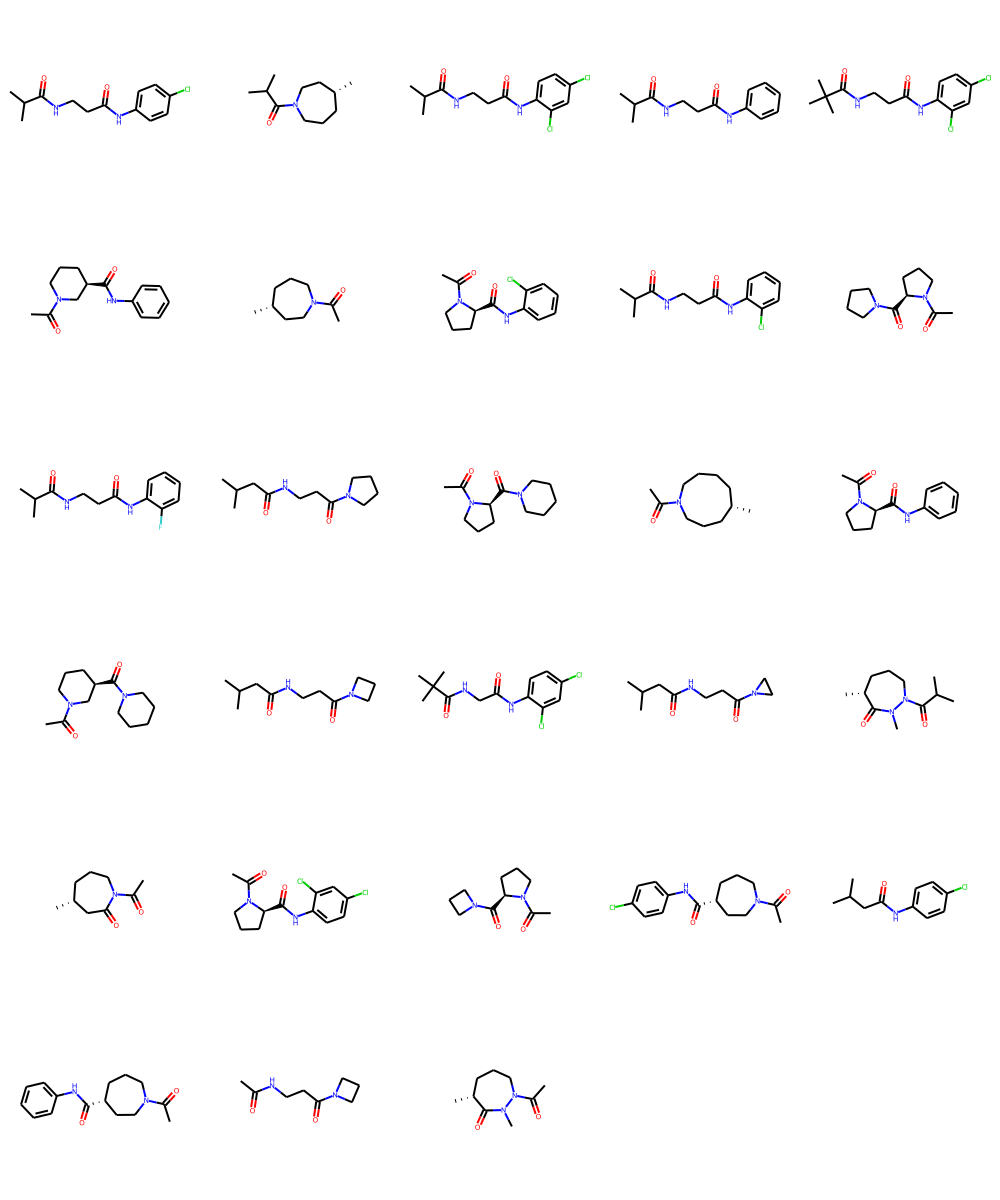

In [9]:
mols = []
for mol in sampled_molecules:
    mols.append(Chem.MolFromSmiles(mol))
Draw.MolsToGridImage(mols, molsPerRow=5)

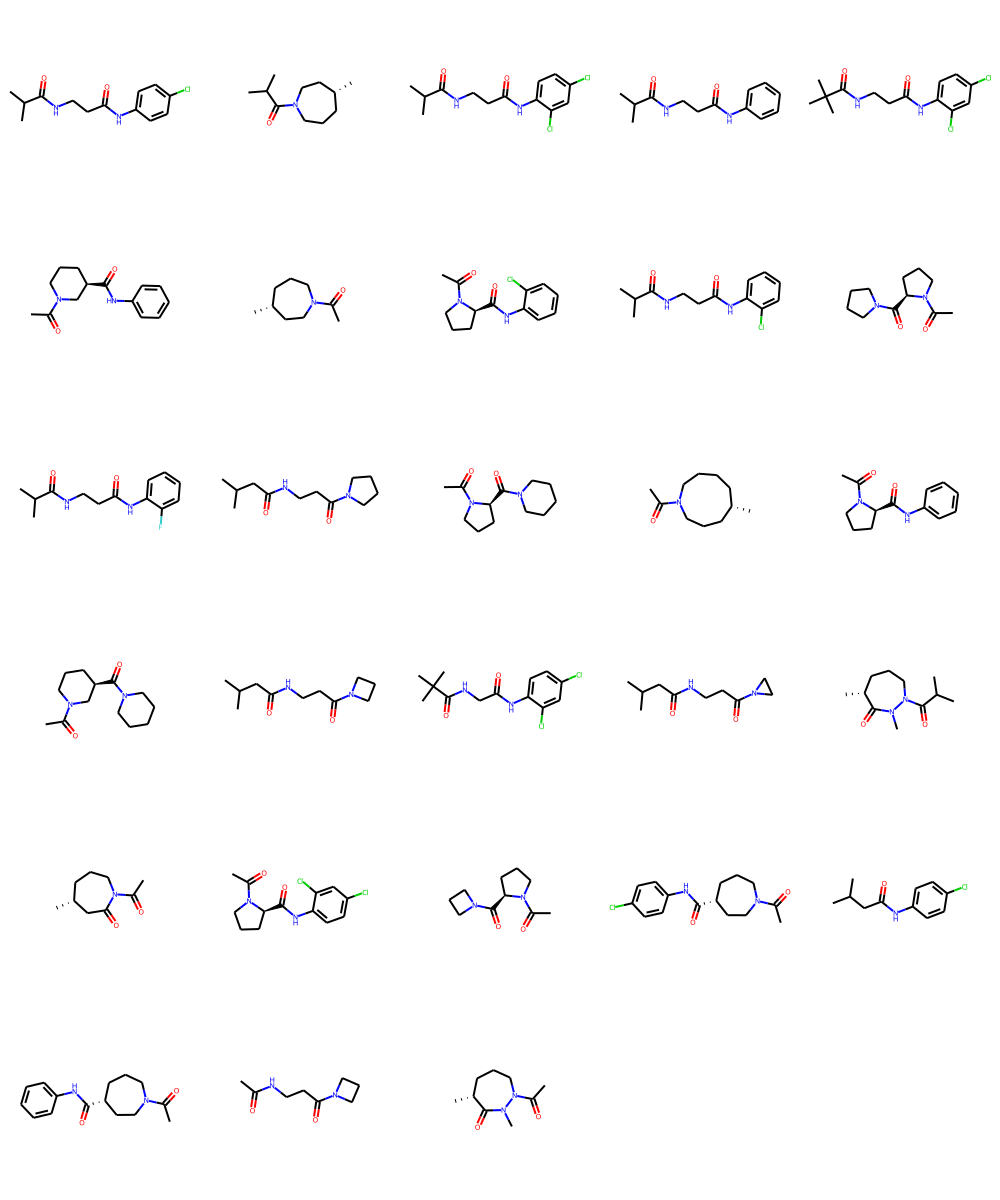

In [10]:
mols = []
for mol in novel_molecules:
    mols.append(Chem.MolFromSmiles(mol))
Draw.MolsToGridImage(mols, molsPerRow=5)

In [11]:
good_mol_list = [x for x in mols if x.GetNumAtoms() >0 and x.GetNumAtoms() < 100]
print(len(good_mol_list))

28


In [12]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]
final_mol_list = [(a,b) for a,b in zip(good_mol_list,qed_list) if b > 0.1]
print(len(final_mol_list))

28


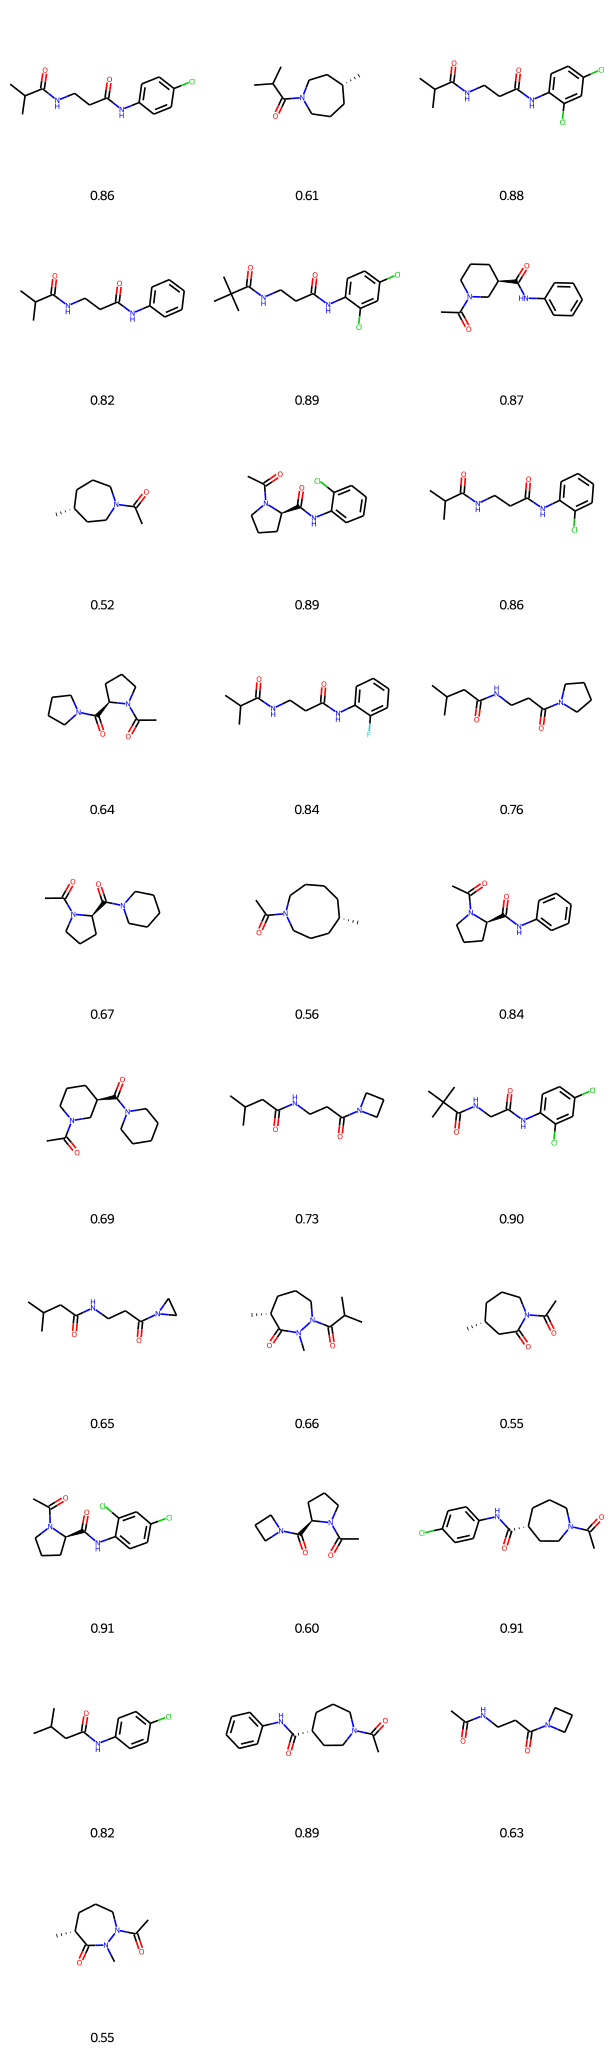

In [13]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x[0] for x in final_mol_list],
               molsPerRow=3,useSVG=True,
               subImgSize=(250, 250),
               legends=[f"{x[1]:.2f}" for x in final_mol_list])

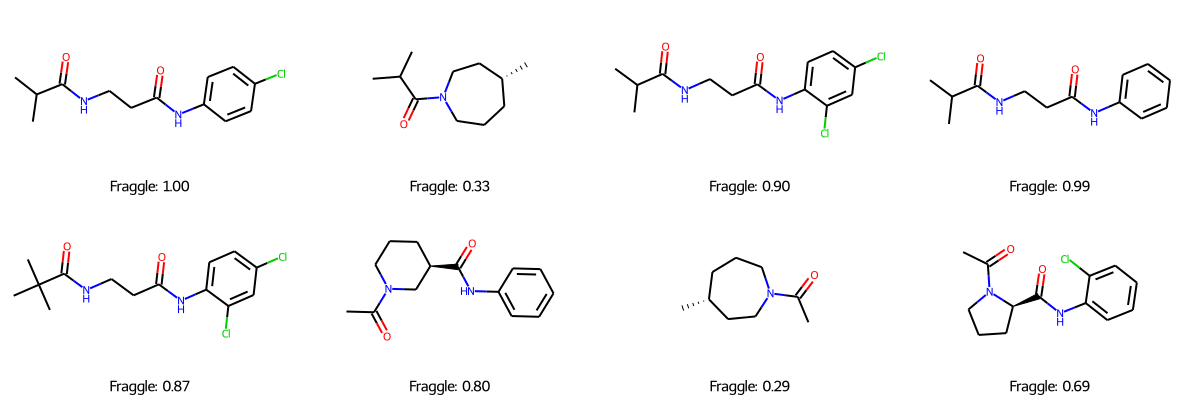

In [14]:
from rdkit.Chem.Fraggle import FraggleSim
 
fraggle_similarity = []
for (sim, match) in [FraggleSim.GetFraggleSimilarity(mols[0], mols[i]) for i in range(len(mols))]:
    fraggle_similarity.append(sim)
Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(300,200), legends=['Fraggle: {:.2f}'.format(i) for i in fraggle_similarity])

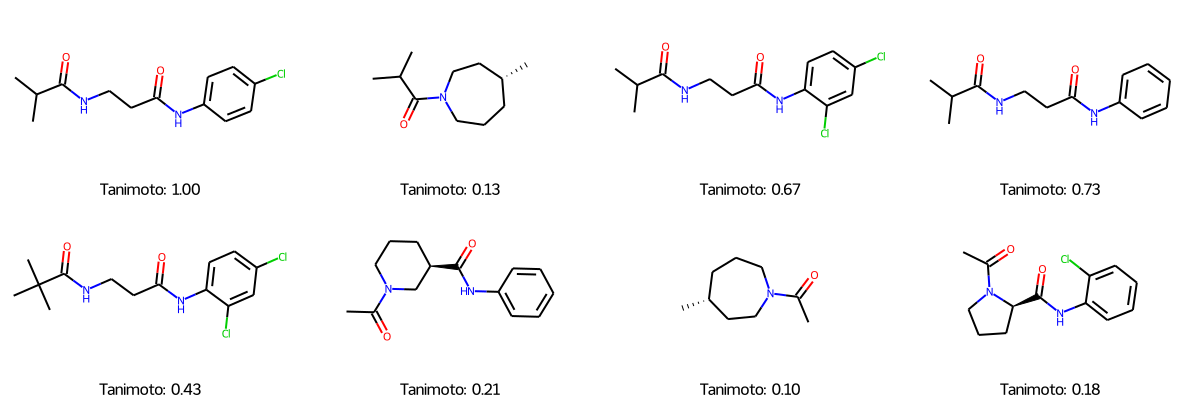

In [15]:
from rdkit.Chem import AllChem, Draw
from rdkit import rdBase, Chem, DataStructs

morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in mols]
tanimoto = DataStructs.BulkTanimotoSimilarity(morgan_fp[0], morgan_fp)
Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(300,200), legends=['Tanimoto: {:.2f}'.format(i) for i in tanimoto])

In [16]:
import rdkit
from rdkit.Chem import Descriptors 
tspa = []
for i in range(len(mols)):
    tspa.append(Descriptors.TPSA(mols[i]))
    
ExactMolWt = []
for i in range(len(mols)):
    ExactMolWt.append(Descriptors.ExactMolWt(mols[i]))

HeavyAtomMolWt = []
for i in range(len(mols)):
    HeavyAtomMolWt.append(Descriptors.HeavyAtomMolWt(mols[i]))
    
MolWt = []
for i in range(len(mols)):
    MolWt.append(Descriptors.MolWt(mols[i]))
    
MolLogP = []
for i in range(len(mols)):
    MolLogP.append(Descriptors.MolLogP(mols[i]))
    
qed = []
for i in range(len(mols)):
    qed.append(QED.qed(mols[i]))
    
numatoms = []
for i in range(len(mols)):
    numatoms.append(mols[i].GetNumAtoms())
    
smiles_list = []
for i in range(len(mols)):
    smiles_list.append(Chem.MolToSmiles(mols[i]))
    
nhbacceptors = []
for i in range(len(mols)):
    nhbacceptors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBA((mols[i])))
nbdonors = []
for i in range(len(mols)):
    nbdonors.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD((mols[i])))

In [17]:
df_first_etap = pd.DataFrame(list(zip(tspa, MolLogP, qed,ExactMolWt,MolWt,HeavyAtomMolWt,smiles_list, numatoms,nhbacceptors,nbdonors)), columns = ['tspa', 'logp', 'qed','ExactMolWt','MolWt','HeavyAtomMolWt','smiles_list','num_atoms','h-acc','h-donors'])
df_first_etap.head(5)

,tspa,logp,qed,ExactMolWt,MolWt,HeavyAtomMolWt,smiles_list,num_atoms,h-acc,h-donors
0,58.20,2.4408,0.861737,268.097855,268.744,251.608,CC(C)C(=O)NCCC(=O)Nc1ccc(Cl)cc1,18,2,2
1,20.31,2.2910,0.610524,183.162314,183.295,162.127,CC(C)C(=O)N1CCC[C@@H](C)CC1,13,1,0
2,58.20,3.0942,0.877888,302.058883,303.189,287.061,CC(C)C(=O)NCCC(=O)Nc1ccc(Cl)cc1Cl,19,2,2
3,58.20,1.7874,0.815626,234.136828,234.299,216.155,CC(C)C(=O)NCCC(=O)Nc1ccccc1,17,2,2
4,58.20,3.4843,0.892971,316.074533,317.216,299.072,CC(C)(C)C(=O)NCCC(=O)Nc1ccc(Cl)cc1Cl,20,2,2


In [18]:
df_first_etap.describe()

,tspa,logp,qed,ExactMolWt,MolWt,HeavyAtomMolWt,num_atoms,h-acc,h-donors
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,45.442857,1.792682,0.750247,232.655686,233.029107,215.209107,16.071429,1.857143,0.892857
std,11.645159,1.010632,0.133327,45.362555,45.667899,45.938734,2.651744,0.356348,0.785955
min,20.310000,-0.255100,0.520654,155.131014,155.241000,138.105000,11.000000,1.000000,0.000000
25%,40.620000,1.123350,0.635811,197.632915,197.762000,180.122000,14.000000,2.000000,0.000000
50%,49.410000,1.835500,0.790064,229.144653,229.301500,210.149500,16.500000,2.000000,1.000000
75%,51.607500,2.440800,0.868872,266.586118,267.232000,251.608000,18.000000,2.000000,1.250000
max,58.200000,3.484300,0.912748,316.074533,317.216000,299.072000,20.000000,2.000000,2.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ExactMolWt', ylabel='Density'>

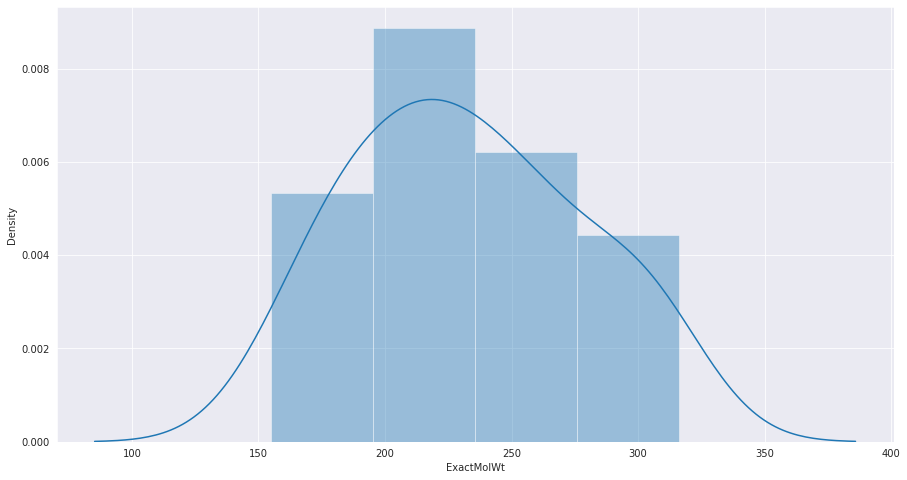

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap['ExactMolWt'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='h-acc', ylabel='Density'>

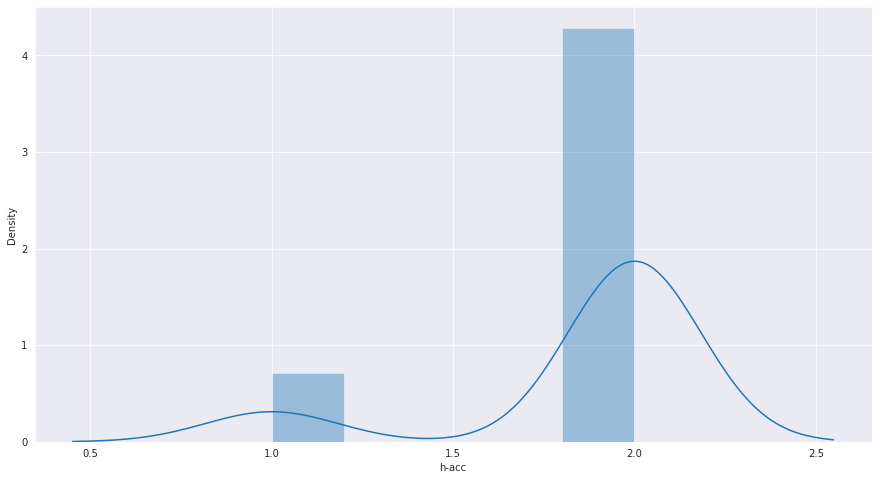

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap['h-acc'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='h-donors', ylabel='Density'>

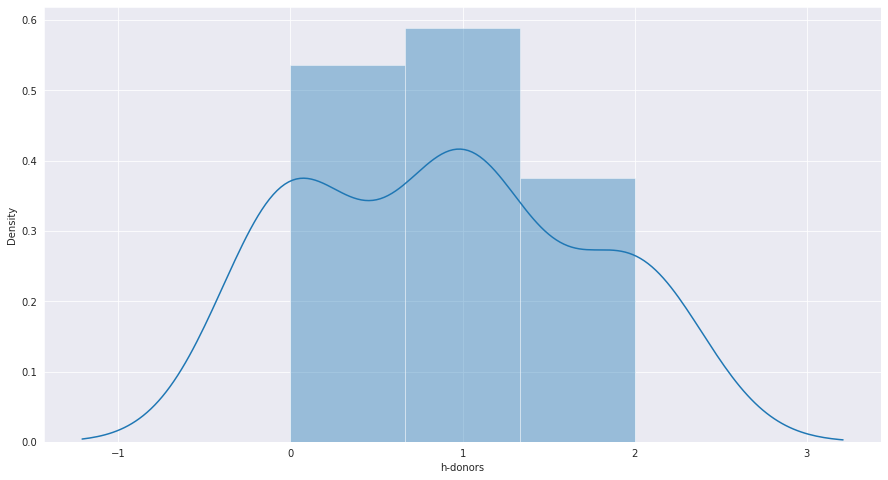

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap['h-donors'])

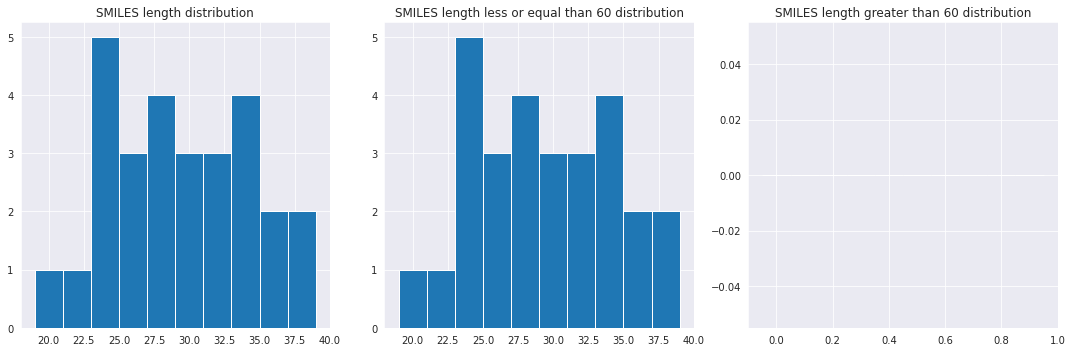

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_title("SMILES length distribution")
axes[0].hist(df_first_etap['smiles_list'].str.len(), align = 'left')
axes[1].set_title("SMILES length less or equal than 60 distribution")
axes[1].hist(df_first_etap[df_first_etap['smiles_list'].str.len() <= 60]['smiles_list'].str.len(), align = 'left')
axes[2].set_title("SMILES length greater than 60 distribution")
axes[2].hist(df_first_etap[df_first_etap['smiles_list'].str.len() > 60]['smiles_list'].str.len(), align = 'left')
fig.tight_layout()


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='qed', ylabel='Density'>

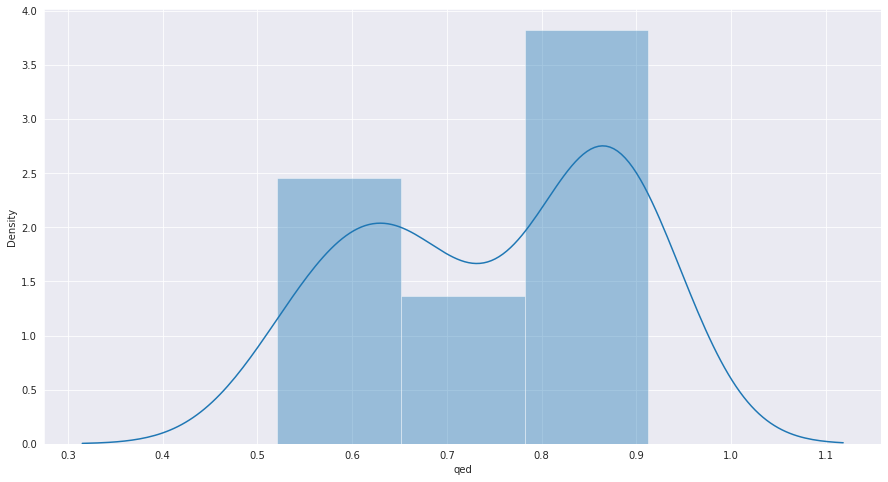

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap['qed'])


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logp', ylabel='Density'>

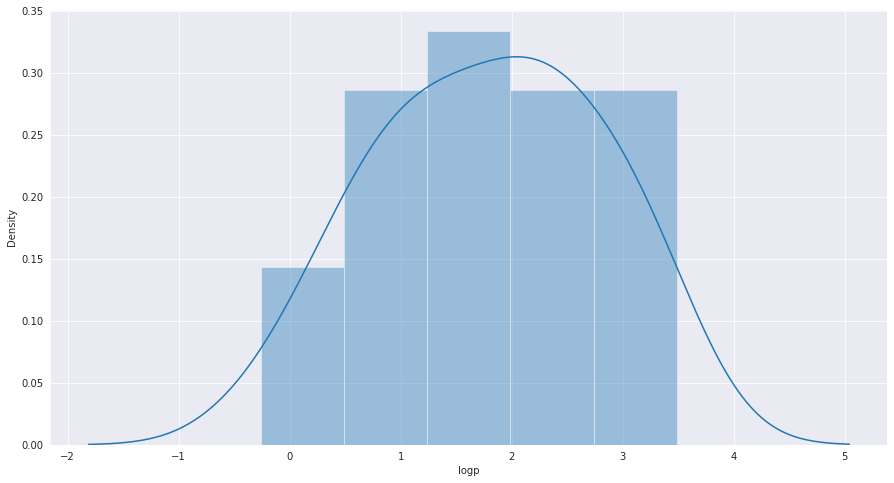

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap['logp'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_atoms', ylabel='Density'>

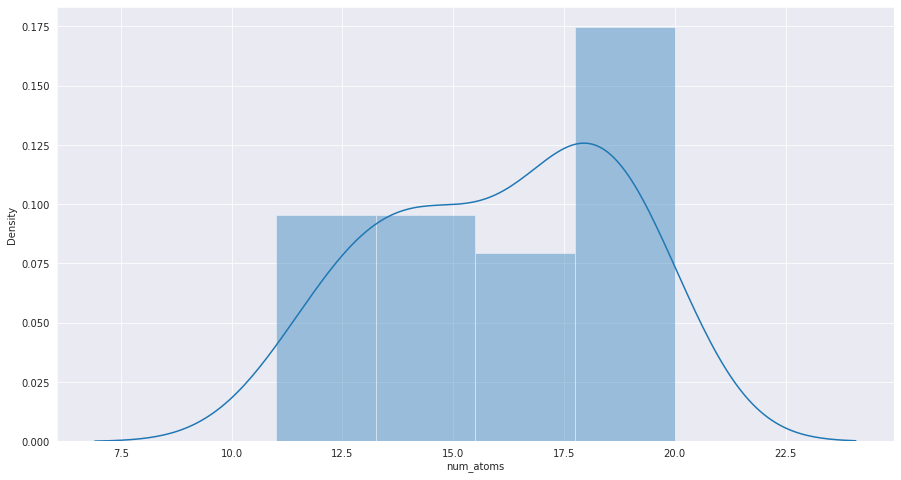

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))
sns.distplot(df_first_etap['num_atoms'])